**Executive Summary**<br>


**Use Case:**<br>

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sb
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import yfinance as yf
yf.pdr_override()

**Data Selection:**<br>
We chose to use the price of the *SPY*, which tracks the S&P 500 Index, for this study because it is less volatile than individual company stocks and may be easier to predict future price fluctuations.The historical prices of *SPY* can be obtained using Yahoo Finance (finance.yahoo.com). We selected data for 2020-2022 for our trainin, and selected the data in 2023 for validation.

In [21]:
# read the history price of spy between 2020-01-01 to 2022-12-31 from Yahoo into a DataFrame df
ticker = "spy"
start = dt.datetime(2020,1,1)
end = dt.datetime(2023,3,31)
df_raw = pdr.get_data_yahoo(ticker, start, end)
df = df_raw[["Adj Close"]]
df.columns =['day_0']

[*********************100%***********************]  1 of 1 completed


In [95]:
# only analyse the Adjust Close price in this research
# df = df['Adj Close']
# only analyse how past 5, 10 and 20 days price change can affect next one day's stock price
# Set different lengths of historical prices for training and prediction. Here the periods are set to the past 3, 5, 10 and 20 days.
days_past = [3, 5, 10]
days_next = [1]

df3, df5, df10 = df.copy(), df.copy(), df.copy()
dfs = [df3, df5, df10]

for i, past_days in enumerate(days_past): # past_days are 3, 5, 10
    # df are df3, df5, df10
    df_cur = dfs[i]
    for day in range(1, past_days + 1): # day is 1 - 3, 1 - 5, 1 - 10
        df_cur[f'day_{day}'] = df_cur['day_0'].shift(-day)
        df_cur[f'change_day_{day}'] = df_cur[f'day_{day}'] / df_cur[f'day_{day-1}'] - 1
    
    day += 1 # day is 4, 6, 11
    df_cur[f'day_{day}'] = df_cur['day_0'].shift(-day)
    df_cur['change_next_day'] = df_cur[f'day_{day}'] > df_cur[f'day_{day-1}']
    
    # drop day_x column
    for day in range(past_days + 2):
        df_cur.drop(f'day_{day}', axis = 1, inplace = True)
    df_cur.dropna(inplace=True)
  


In [96]:
# row number to split test data
split_test = df.index.get_loc(pd.to_datetime('2023-01-03'))
# row number to split validation data
split_valid = round(split_test * 0.8)
print(f'test data split at after row {split_test}, valid data split at after row {split_valid}')
# train data
df5_train_features = df5[ : split_valid].copy()
df5_train_label = df5_train_features[['change_next_day']]
df5_train_features.drop(columns = ['change_next_day'], inplace = True)

# validation data
df5_val_features = df5[split_valid : split_test].copy()
df5_val_label = df5_val_features[['change_next_day']]
df5_val_features.drop(columns = ['change_next_day'], inplace = True)

# test data
df5_test_features = df5[split_test : ].copy()
df5_test_label = df5_test_features[['change_next_day']]
df5_test_features.drop(columns = ['change_next_day'], inplace = True)


test data split at after row 756, valid data split at after row 605


In [99]:
#print(df5_val_label.tail())
df5_test_label.tail()

,change_next_day
Date,
2023-03-17,True
2023-03-20,False
2023-03-21,True
2023-03-22,True
2023-03-23,False


In [5]:
# Set different lengths of historical prices for training and prediction. Here the periods are set to the past 3, 5, 10 and 20 days.
# days_past = [3,5,10,20]
# Set different lengths of time to predict future price changes. Here the periods are set to the next 1, 3 and 5 days.
# days_next = [1,3,5]

# In the current research, we choose to use "Adj Close" values to construct a sequence price in the past and the prediction target.
# adj_close = pd.DataFrame(df['Adj Close'])
# Create an empty list, then add all the newly built data frames into the list as the final datasets to train machine learning models.
# dfs = []

**Data Selection:**<br>
We use the "Adj Close" price to see if a meaningful result can be obtained and ignore other price data this time.

**Data Selection:**<br>
Construct different lengths(past 3, 5, 10, 20 days) of the price series and associate them with future prices(next 1, 3, 5 days).We also calculated the price change rate in the past days(the change rate of each day's price compared to the previous day's price) and added the result to the data frame.

**Data Selection:**<br>
Show the structure of the newly constructed data frame. Here only shows the data associated the price of the past 20 days with the next 5 days.

In [100]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import random
import graphviz 
random.seed(0)

In [117]:
#dt_exams = DecisionTreeClassifier(max_depth=2, min_samples_leaf=10, min_samples_split=10)
dt = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, min_samples_split=10)
dt.fit(df5_train_features,df5_train_label)
dt.score(df5_val_features,df5_val_label)

0.5496688741721855

In [119]:
dt.score(df5_test_features,df5_test_label)

0.5535714285714286

[Text(0.5416666666666666, 0.875, 'x[4] <= 0.018\ngini = 0.494\nsamples = 605\nvalue = [269, 336]'),
 Text(0.3333333333333333, 0.625, 'x[1] <= 0.01\ngini = 0.489\nsamples = 567\nvalue = [241, 326]'),
 Text(0.16666666666666666, 0.375, 'x[1] <= -0.003\ngini = 0.495\nsamples = 454\nvalue = [204, 250]'),
 Text(0.08333333333333333, 0.125, 'gini = 0.461\nsamples = 178\nvalue = [64, 114]'),
 Text(0.25, 0.125, 'gini = 0.5\nsamples = 276\nvalue = [140, 136]'),
 Text(0.5, 0.375, 'x[4] <= 0.008\ngini = 0.44\nsamples = 113\nvalue = [37, 76]'),
 Text(0.4166666666666667, 0.125, 'gini = 0.361\nsamples = 89\nvalue = [21, 68]'),
 Text(0.5833333333333334, 0.125, 'gini = 0.444\nsamples = 24\nvalue = [16, 8]'),
 Text(0.75, 0.625, 'x[2] <= -0.013\ngini = 0.388\nsamples = 38\nvalue = [28, 10]'),
 Text(0.6666666666666666, 0.375, 'gini = 0.142\nsamples = 13\nvalue = [12, 1]'),
 Text(0.8333333333333334, 0.375, 'x[2] <= 0.012\ngini = 0.461\nsamples = 25\nvalue = [16, 9]'),
 Text(0.75, 0.125, 'gini = 0.5\nsamples

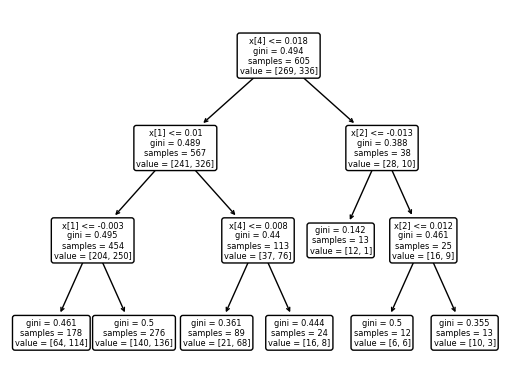

In [111]:
tree.plot_tree(dt, rounded=True)

In [123]:
test = df5_test_features[:5].copy()
print(test)
print(dt.predict(test))
df5_test_label[:5]


            change_day_1  change_day_2  change_day_3  change_day_4  \
Date                                                                 
2023-01-03      0.007720     -0.011413      0.022932     -0.000567   
2023-01-04     -0.011413      0.022932     -0.000567      0.007013   
2023-01-05      0.022932     -0.000567      0.007013      0.012648   
2023-01-06     -0.000567      0.007013      0.012648      0.003641   
2023-01-09      0.007013      0.012648      0.003641      0.003879   

            change_day_5  
Date                      
2023-01-03      0.007013  
2023-01-04      0.012648  
2023-01-05      0.003641  
2023-01-06      0.003879  
2023-01-09     -0.001832  
[ True False False False  True]


,change_next_day
Date,
2023-01-03,True
2023-01-04,True
2023-01-05,True
2023-01-06,False
2023-01-09,False


**Data Cleaning**<br>
The original dataset is clean without any NA value.<br> 
Constructing the past price series result in some NA values in the data frame. Those rows with NA values are at the end of the data frame. The reason is that at the end of the original data frame, not enough data can be used to construct a complete price series. For example, since the original data ends on the date 2022-12-30, there is no way to build a 20 days price series starting from that day.<br>
The maximum number of rows with NA data is 20+5-1 = 24.
Compared with two years' price data, the percentage is less than 5%. Therefore, we can drop those rows and get a clean data set.

In [81]:
copy = test.copy
copy

<bound method NDFrame.copy of             Day2_Change  Day3_Change  Day4_Change  Day5_Change
Date                                                          
2022-05-26     0.024549    -0.005611    -0.008088     0.019043
2022-05-27    -0.005611    -0.008088     0.019043    -0.016412
2022-05-31    -0.008088     0.019043    -0.016412     0.003045
2022-06-01     0.019043    -0.016412     0.003045     0.009592
2022-06-02    -0.016412     0.003045     0.009592    -0.010872>

In [93]:
from sklearn.svm import SVC

In [107]:
svm_gamma_01 = SVC(kernel='rbf', gamma=0.1)
svm_gamma_01.fit(feature_train, label_train)
print("Gamma = 0.1")
print("Accuracy:", svm_gamma_01.score(feature_val, label_val))
svm_gamma_1 = SVC(kernel='rbf', gamma=1)
svm_gamma_1.fit(feature_train, label_train)
print("Gamma = 1")
print("Accuracy:", svm_gamma_1.score(feature_val, label_val))

Gamma = 0.1
Accuracy: 0.423841059602649
Gamma = 1
Accuracy: 0.423841059602649


In [103]:
# Degree = 2
svm_degree_2 = SVC(kernel='poly', degree=2)
svm_degree_2.fit(feature_train, label_train)
print("Polynomial kernel of degree = 2")
print("Accuracy:", svm_degree_2.score(feature_val, label_val))
#utils.plot_model(features, labels, svm_degree_2)

# Degree = 4
svm_degree_4 = SVC(kernel='poly', degree=5)
svm_degree_4.fit(feature_train, label_train)
print("Polynomial kernel of degree = 4")
print("Accuracy:", svm_degree_4.score(feature_val, label_val))
#utils.plot_model(features, labels, svm_degree_4)

Polynomial kernel of degree = 2
Accuracy: 0.423841059602649
Polynomial kernel of degree = 4
Accuracy: 0.4370860927152318


**Analysis and Visualization:**<br>
First, we would like to look at the distribution of the price changes over the last 3, 5, 10 and 20 days

count    732.000000
mean       1.000463
std        0.015831
min        0.890576
25%        0.993512
50%        1.001070
75%        1.008290
max        1.090603
Name: Day3_Change, dtype: float64


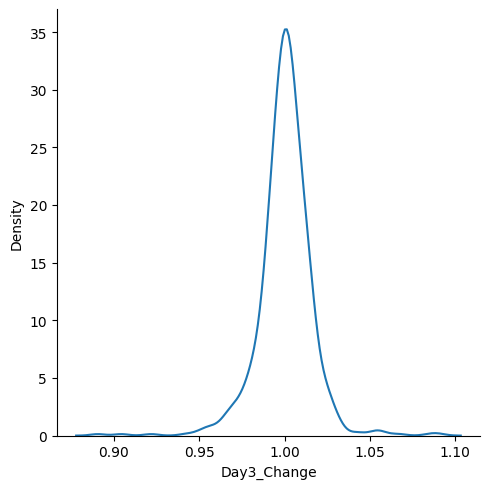

In [11]:
# df has the data for past 20 days' and next 5 day's price change
df = dfs[-1]
# use change to save mean change rate for different days
change = pd.DataFrame({"Change Rate":[]})

# the statistics for past 3 days' price change
print(df['Day3_Change'].describe())
sb.displot(df['Day3_Change'],kind = 'kde')

# save mean value to change
change.loc['3 Days'] = df['Day3_Change'].mean()

**Analysis and Visualization:**<br>
From the results of the above analysis, it can be seen that over the 3-days period, the price will rise by an average of 0.046%, and the price change shows the characteristics of the normal distribution, with a standard deviation of 1.583%.

count    732.000000
mean       1.000504
std        0.015872
min        0.890576
25%        0.993512
50%        1.001070
75%        1.008327
max        1.090603
Name: Day5_Change, dtype: float64


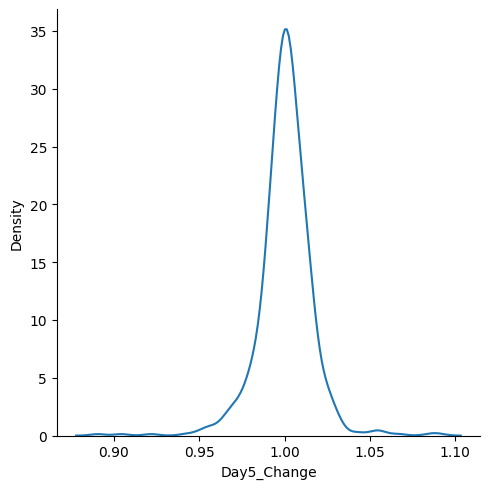

In [12]:
# the statistics for past 5 days' price change
print(df['Day5_Change'].describe())
sb.displot(df['Day5_Change'],kind = 'kde')

# save mean value to change
change.loc['5 Days'] = df['Day5_Change'].mean()

**Analysis and Visualization:**<br>
From the results of the above analysis, it can be seen that over the 5-days period, the price will rise by an average of 0.050%, and the price change shows the characteristics of the normal distribution, with a standard deviation of 1.587%.

count    732.000000
mean       1.000447
std        0.015894
min        0.890576
25%        0.993441
50%        1.000906
75%        1.008327
max        1.090603
Name: Day10_Change, dtype: float64


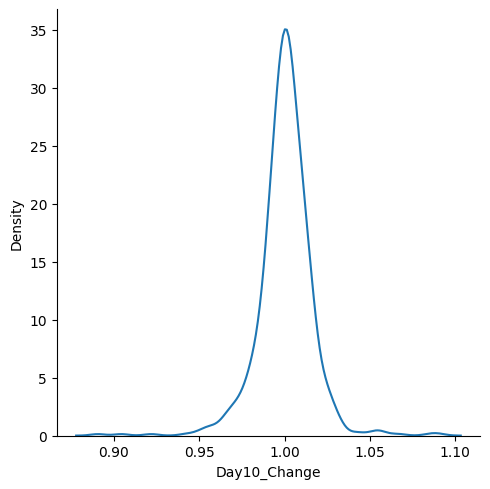

In [13]:
# the statistics for past 10 days' price change
print(df['Day10_Change'].describe())
sb.displot(df['Day10_Change'],kind = 'kde')

# save mean value to change
change.loc['10 Days'] = df['Day10_Change'].mean()

**Analysis and Visualization:**<br>
From the results of the above analysis, it can be seen that over the 5-days period, the price will rise by an average of 0.045%, and the price change shows the characteristics of the normal distribution, with a standard deviation of 1.589%.

count    732.000000
mean       1.000402
std        0.015941
min        0.890576
25%        0.993356
50%        1.000899
75%        1.008397
max        1.090603
Name: Day20_Change, dtype: float64


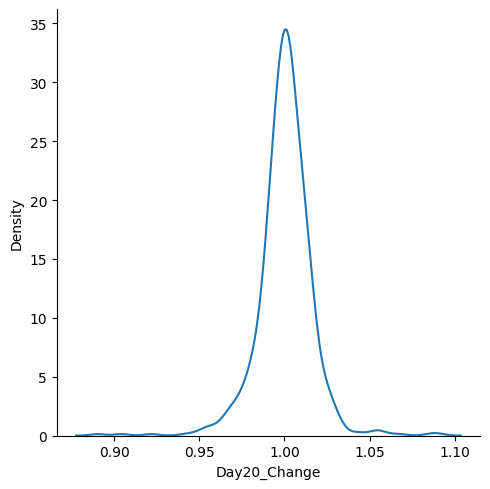

In [14]:
# the statistics for past 20 days' price change
print(df['Day20_Change'].describe())
sb.displot(df['Day20_Change'],kind = 'kde')

# save mean value to change
change.loc['20 Days'] = df['Day20_Change'].mean()

**Analysis and Visualization:**<br>
From the results of the above analysis, it can be seen that over the 5-days period, the price will rise by an average of 0.040%, and the price change shows the characteristics of the normal distribution, with a standard deviation of 1.594%.

**Analysis and Visualization:**<br>
The next 3/5 day's price change distribution is the same as the past 3/5 day's price change distribution, so no additional analysis is needed. We only need to look at the distribution of price changes over the next 1 day.

count    753.000000
mean       1.000410
std        0.015767
min        0.890576
25%        0.993430
50%        1.000899
75%        1.008228
max        1.090603
Name: Next_1_days_change, dtype: float64


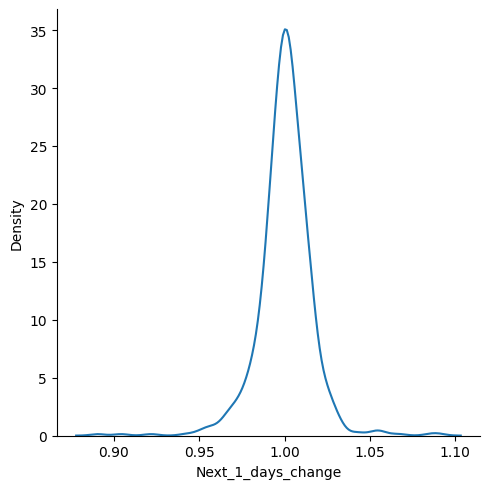

In [15]:
# the statistics for next 1 days' price change
df = dfs[0]
# df has the data for past 3 days' and next 1 day's price change
print(df['Next_1_days_change'].describe())
sb.displot(df['Next_1_days_change'],kind = 'kde')

# save mean value to change
change.loc['1 Day'] = df['Next_1_days_change'].mean()

**Analysis and Visualization:**<br>
The price will rise by an average of 0.041% for 1 day, and the price change shows the characteristics of the normal distribution, with a standard deviation of 1.577%.

**Analysis and Visualization:**<br>
We plot the price change rates of different days in the following and found no apparent relationship between them.

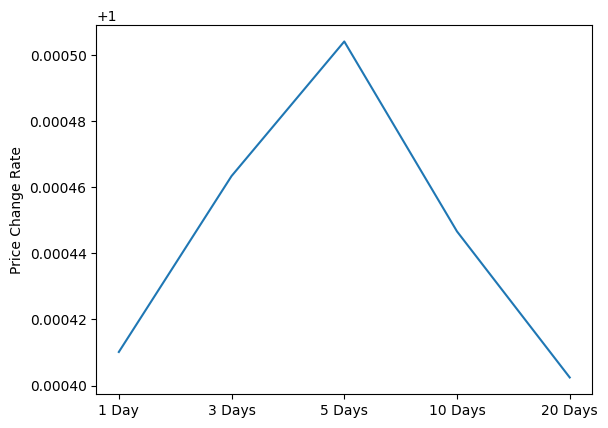

In [16]:
# rerange the data of the change rate for different days
change = change.iloc[[4,0,1,2,3]]
# plot the data frame
plt.ylabel("Price Change Rate")
plt.plot(change)

**Analysis and Visualization:**<br>
We plot the price change of past and next days in the following codes, and found no apparent relationship between them.

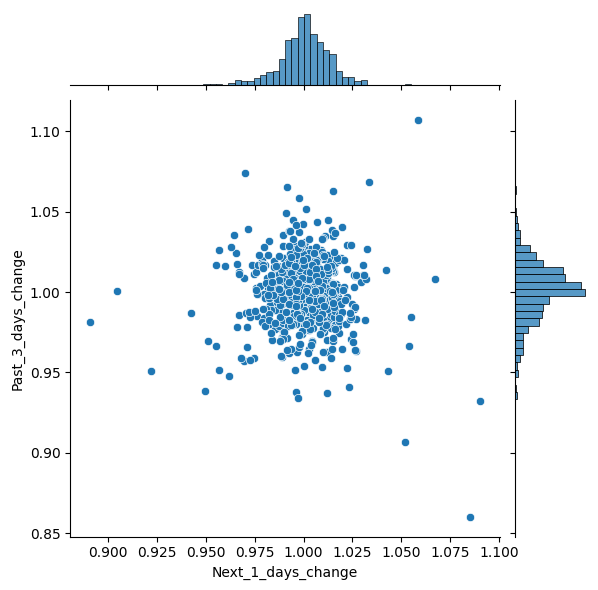

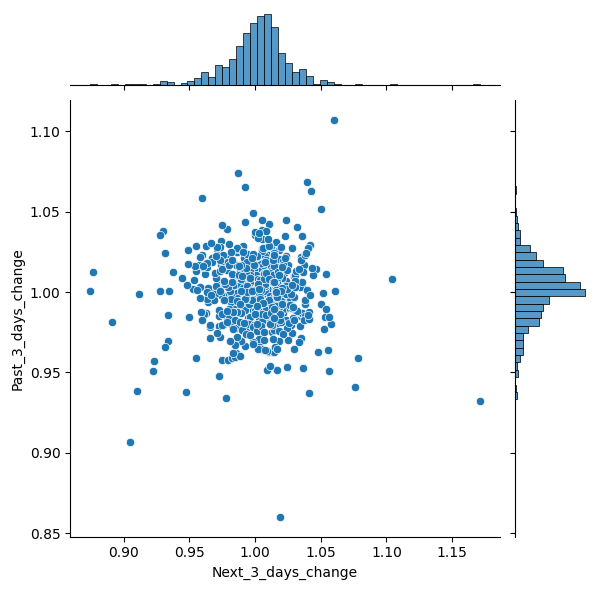

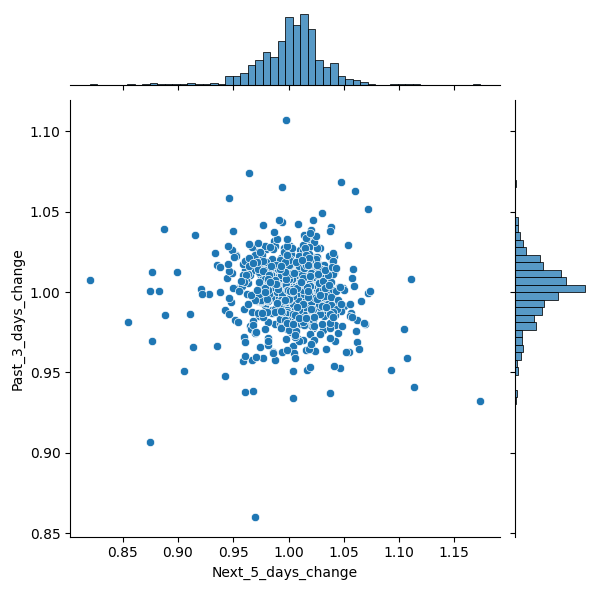

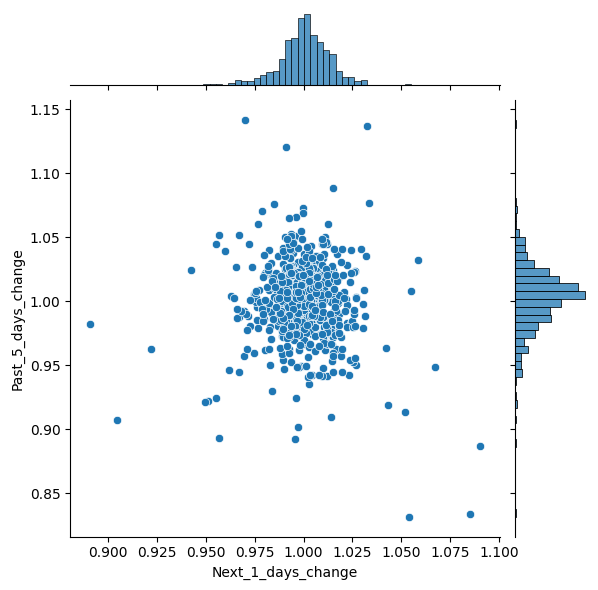

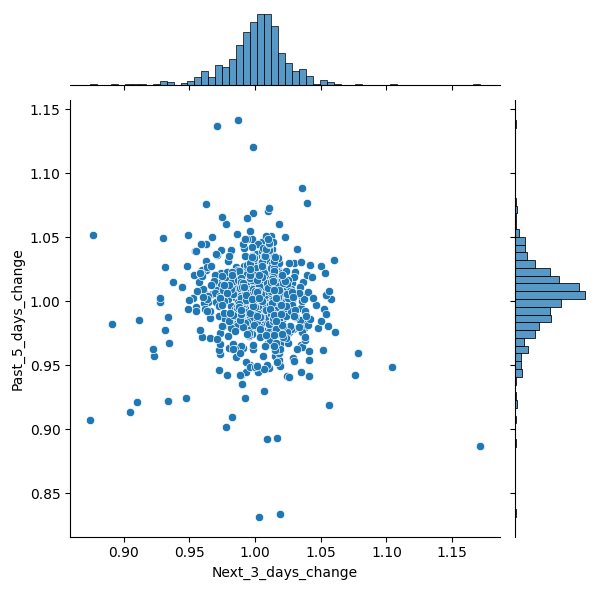

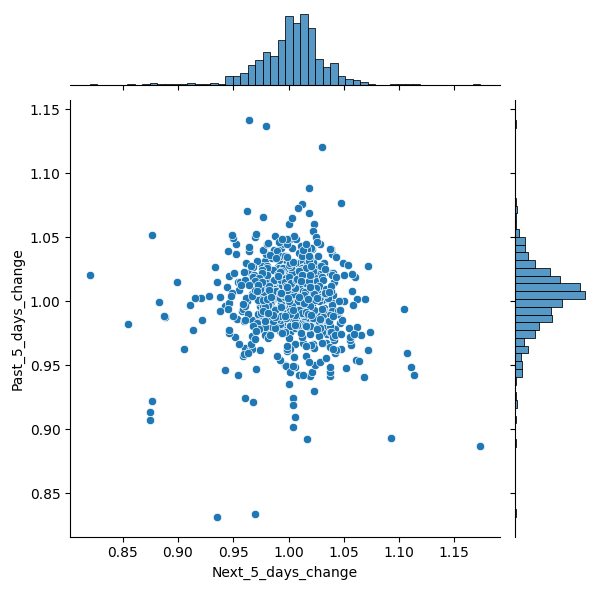

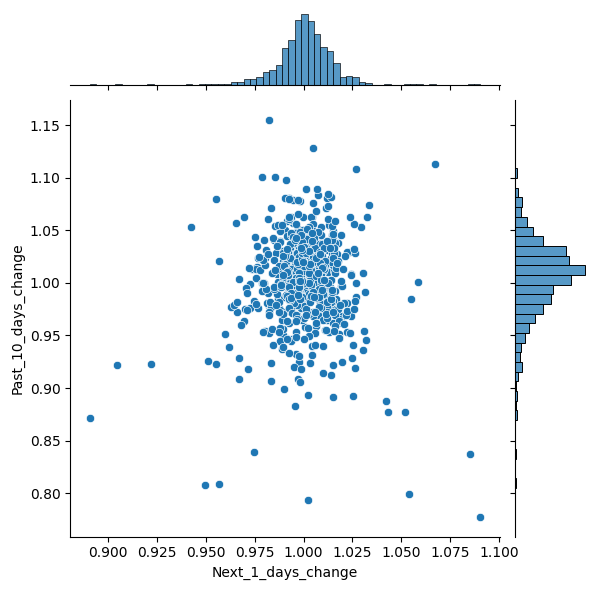

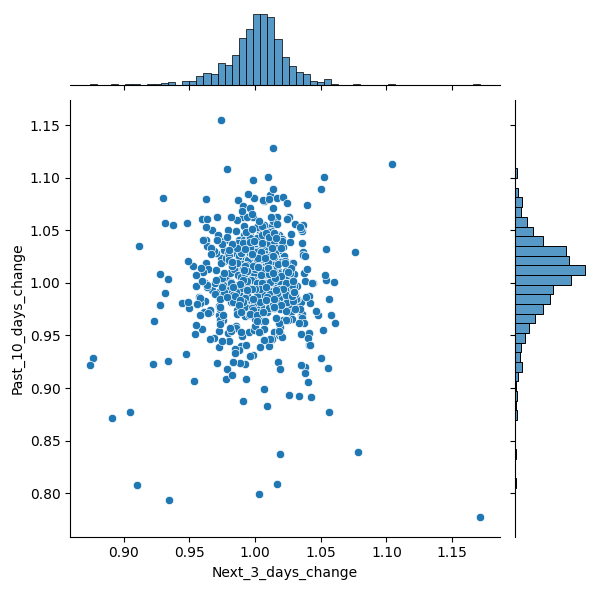

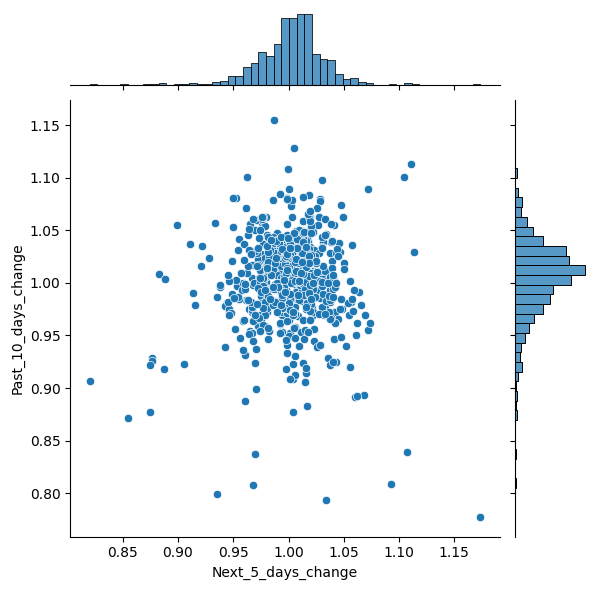

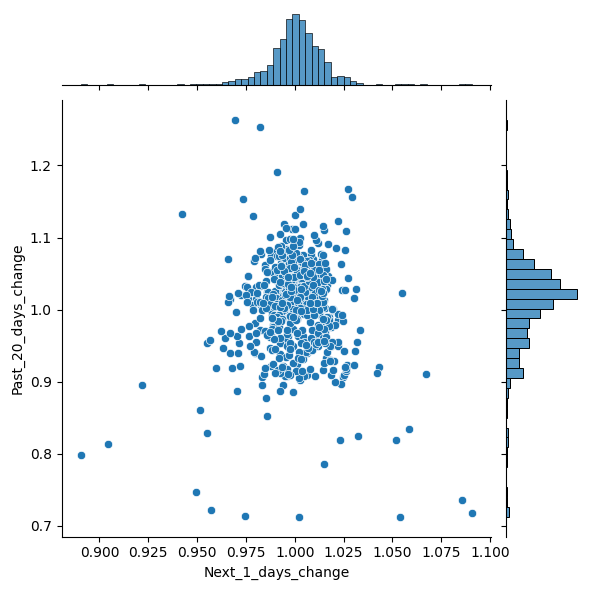

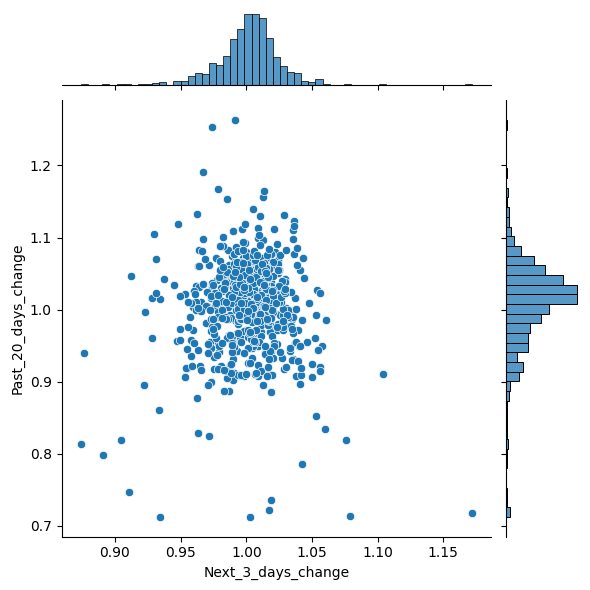

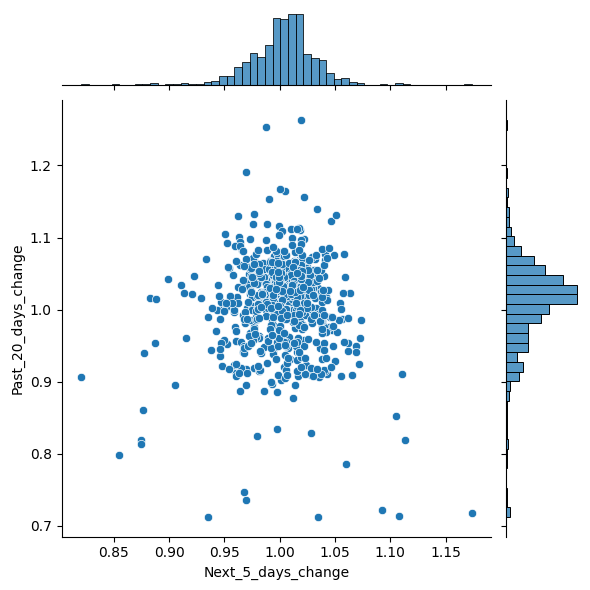

In [17]:
# using joinplot to visulize the relationship between past price change and future price change
for df in dfs:
    sb.jointplot(data=df, x = df.columns[-1], y = df.columns[-3])

**Analysis and Visualization:**<br>
We calculated the correlation between past and future price changes in the following codes and found there is almost no correlation between them.

In [18]:
for df in dfs:
    cor = df.iloc[:,-1].corr(df.iloc[:,-3])
    print(f'The correlation value between {df.columns[-1]} and {df.columns[-3]} is {cor}')

The correlation value between Next_1_days_change and Past_3_days_change is -0.03725430567126824
The correlation value between Next_3_days_change and Past_3_days_change is -0.016485062482032714
The correlation value between Next_5_days_change and Past_3_days_change is -0.04164984295647412
The correlation value between Next_1_days_change and Past_5_days_change is -0.08034000358182272
The correlation value between Next_3_days_change and Past_5_days_change is -0.07054449424475129
The correlation value between Next_5_days_change and Past_5_days_change is -0.056848485203996456
The correlation value between Next_1_days_change and Past_10_days_change is 0.0031972766257405286
The correlation value between Next_3_days_change and Past_10_days_change is 0.030582383242036517
The correlation value between Next_5_days_change and Past_10_days_change is 0.03735357334535163
The correlation value between Next_1_days_change and Past_20_days_change is -0.02072893790784859
The correlation value between Next

**Discussion:** <br>
To obtain a profitable investment strategy, we could classify the future price change into three categories: big rise, big drop, and fluctuation. For example, we can classify a more than 1% increase into the big rise category, classify a more than 1% down into the big drop category, and treat other cases as fluctuation. In this way, we can choose to invest only when the potential returns are high enough to prevent losses.<br>
We already did some rescaling work on the original data in the previous process. For example, we used the price change rate instead of the actual closing price for analysis.<br>
Considering the past price change and future price change show very little correlation. The only possible way to predict the future price change may rely on the changing pattern of past prices. For example, maybe two consecutive days of price change means that the price will continue to rise the next day. To better identify the changing pattern, maybe using 1/0 to identify the price rise/drop is better than using the price change rate for the model training. So we may use price rise/drop(1/0) to replace the price change rate in the following research.